# Load Specter Embeddings

In [11]:
%load_ext autoreload
%autoreload 2

VECTOR_SIZE = 100

## 1. Load Embeddings

In [3]:
VECTOR_COLS = [str(i) for i in range(768)]
COLUMNS = ['cord_uid'] + VECTOR_COLS
import pandas as pd
spector_path = '../data/CORD-19-research-challenge/cord19_specter_embeddings_2020-04-10/cord19_specter_embeddings_2020-04-10.csv'
%time embeddings = pd.read_csv(spector_path, names=COLUMNS).set_index('cord_uid')
embeddings

Wall time: 22.7 s


,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
cord_uid,,,,,,,,,,,,,,,,,,,,,
xqhn0vbp,0.277109,-2.974946,1.103587,9.312441,1.301328,-4.281131,-0.531885,-4.497644,-0.696714,3.888403,...,-0.319249,4.262276,2.845274,-1.656342,-2.584434,-4.678826,3.175534,4.890424,-1.488285,-1.301303
gi6uaa83,-0.344760,-4.762074,3.647769,2.616938,3.856543,-0.460272,0.899565,2.284138,0.590927,2.861983,...,-0.185362,0.603534,1.475987,1.804034,2.819780,-4.039684,-3.027682,0.997251,-0.661524,1.590745
le0ogx1s,-3.257521,-1.720686,1.438893,-1.614458,-3.205178,1.125262,-1.420612,-4.270585,-2.557855,-0.092169,...,-1.691883,0.594955,1.336509,0.036567,-2.065922,0.360089,0.832659,2.954574,-4.601091,-1.097578
fy4w7xz8,0.920366,-3.546179,-2.537739,6.372102,0.025263,-1.991629,-0.612892,0.983194,-2.316126,2.078352,...,-0.412801,0.831824,2.101388,3.283052,-3.075248,-4.381618,1.925288,4.607265,-1.254582,-1.320425
0qaoam29,-1.145982,-5.231421,-1.958305,5.035599,-1.601498,-0.756577,1.757929,1.490937,0.192156,-2.802254,...,0.131644,3.836460,1.115987,1.524282,-2.017589,-5.102140,3.864315,1.679577,1.871223,-0.295825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4xhcamks,-5.418158,-5.245474,3.628956,6.451151,3.634892,-2.335905,0.667048,-0.485650,0.193185,1.170576,...,0.523872,1.136867,0.720693,0.521212,-2.560610,-5.660248,3.487091,0.655311,0.436463,-2.991478
z2rqz3jx,2.785809,-3.396076,2.769620,3.735134,0.345574,-3.188008,-0.511677,-0.106290,0.542728,-3.533303,...,3.259372,0.605949,-5.456649,2.752270,4.745460,-2.562807,0.564394,-6.728393,-3.059293,0.375873
wncuc903,-1.541402,-7.471113,0.566562,10.698986,-0.464386,-1.495992,1.584507,-2.346224,1.693222,-1.344092,...,1.425641,0.519614,5.308790,4.999254,-2.539582,-0.886018,6.917359,5.901351,-3.215071,1.838168


## 2. Reduce Dimensions

In [4]:
from sklearn.decomposition import PCA

pca = PCA(n_components=100)
embeddings_100 = pca.fit_transform(embeddings)

## 3. Create Annoy Index

In [9]:
from annoy import AnnoyIndex
from pathlib import Path

def cord_support_dir():
    return Path('../cord') / 'cordsupport'

SIMILARITY_INDEX_PATH = str((Path(cord_support_dir()) / 'PaperSimilarity.ann').resolve())

annoy_index = AnnoyIndex(100, 'angular')  
for i in range(embeddings_100.shape[0]):
    annoy_index.add_item(i, embeddings_100[i,:])

annoy_index.build(30)
annoy_index.save(SIMILARITY_INDEX_PATH)

True

In [10]:
assert annoy_index.get_n_items() == len(embeddings), \
                        f'expected {len(embeddings)} items in the annoy index but was {annoy_index.get_n_items()}'

## 4. Downsample to 2d and 1d, and get cluster ids

In [13]:
import numpy as np
RANDOM_STATE = 42
def kmean_labels(docvectors, n_clusters=8, random_state=RANDOM_STATE):
    print('Setting cluster labels')
    from sklearn.cluster import KMeans
    kmeans = KMeans(n_clusters=n_clusters,
                    random_state=random_state).fit(docvectors)
    return kmeans.labels_, kmeans


def downsample(docvectors, dimensions=2):
    print(f'Downsampling to {dimensions}D embeddings')
    pca = PCA(n_components=dimensions, svd_solver='full')
    docvectors_downsampled = pca.fit_transform(docvectors)
    return np.squeeze(docvectors_downsampled)

vectors_2d = downsample(embeddings,2)
vectors_1d = downsample(embeddings,1)
cluster_ids, kmeans = kmean_labels(embeddings, n_clusters=8)

Downsampling to 2D embeddings
Downsampling to 1D embeddings
Setting cluster labels


## 4. Save to cord support dir

In [15]:
from pathlib import PurePath
document_vectors = pd.DataFrame({'cluster': cluster_ids,
                                 'x': vectors_2d[:,0],
                                 'y':  vectors_2d[:,1],
                                 '1d': vectors_1d.tolist(),
                                 '2d': vectors_2d.tolist()
                                }, index=embeddings.index)
document_vectors.to_parquet(PurePath(cord_support_dir()) / 'DocumentVectors.pq')

In [16]:
document_vectors = pd.read_parquet(PurePath(cord_support_dir()) / 'DocumentVectors.pq')

In [17]:
document_vectors

,cluster,x,y,1d,2d
cord_uid,,,,,
xqhn0vbp,0,-16.746437,13.216263,-16.746437,"[-16.74643680817409, 13.216263026643853]"
gi6uaa83,0,1.966327,-2.207469,1.966327,"[1.9663268777746572, -2.2074688325530283]"
le0ogx1s,6,31.708845,8.587331,31.708845,"[31.708844578373675, 8.587330999326701]"
fy4w7xz8,3,-15.848964,16.420672,-15.848964,"[-15.848964066106522, 16.420671871807553]"
0qaoam29,0,-11.824390,16.038072,-11.824390,"[-11.824389780999928, 16.038071989756528]"
...,...,...,...,...,...
4xhcamks,0,-14.387657,14.782875,-14.387657,"[-14.387657268099522, 14.78287474341333]"
z2rqz3jx,2,61.959281,-10.688373,61.959281,"[61.95928137466404, -10.68837326333497]"
wncuc903,5,-11.071418,-17.693837,-11.071418,"[-11.071418250812455, -17.69383729083056]"


## Chart

In [18]:
import altair as alt

alt.Chart(document_vectors.sample(5000)).mark_circle().encode(
    x='x',
    y='y',
    color='cluster:N'
)

alt.Chart(...)

In [19]:
from cord import ResearchPapers

In [20]:
metadata = ResearchPapers.load_metadata()

Loading metadata from ..\data\CORD-19-research-challenge
Cleaning metadata
Applying tags to metadata


In [21]:
COLS = ['cord_uid', 'title','covid_related','virus','coronavirus','sars', 'cluster']
docs = document_vectors.merge(metadata, on='cord_uid', how='left')[COLS]

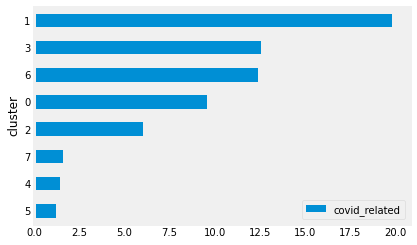

In [22]:
cluster_pct = docs[['cluster', 'covid_related']].groupby('cluster').sum() * 100 / \
                    docs[['cluster', 'covid_related']].groupby('cluster').count()

import matplotlib.style as style
style.use('fivethirtyeight')
cluster_pct.sort_values('covid_related').plot.barh(grid=False);

In [23]:
docs.query("cluster==1").sample(200)

,cord_uid,title,covid_related,virus,coronavirus,sars,cluster
42591,k2rzgrqe,A mathematical model of the transmission of mi...,False,True,True,False,1
34617,5a3e3zkh,The pathological changes and related studies o...,True,True,True,False,1
13973,q2qmfvng,Australian Hajj pilgrims’ knowledge about MERS...,False,False,False,False,1
50910,ktc6sp3f,Behavioral considerations and impact on person...,True,True,True,False,1
30932,6l1fyl93,Initial rapid and proactive response for the C...,True,False,False,False,1
...,...,...,...,...,...,...,...
42036,tt7dvhbd,The neglected health of international migrant ...,True,False,False,False,1
34629,vt8w7z01,All eyes on Coronavirus-What do we need to kno...,False,True,True,False,1
36431,5611e47t,Studies of rhinoviruses and coronaviruses at t...,False,True,True,False,1
36105,endh4ybh,Approches applicables à la lutte contre les ma...,False,True,False,False,1
